In [1]:
from somefunctions import *

C:\Users\nicol\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Configuration parameters
Easier if we put them all togheter

In [2]:
reg = 1e-6  #regularization term
pool_size = (2, 2)
patch_size = 16
input_size = 16 # for now is the patch size
batch_size = 250
nb_epoch = 1 #very small, only preliminary tests
learning_rate = 0.001
        

# Function to generate the minibatch
This function will be called during the training. <br>
Here we can also do some feature augmentation, for example. But maybe is more efficient to flip all the images before. <br>
TODO: take a random patch of dimension (input_size x input_size)

In [3]:
def generate_minibatch(X,Y):
    """
    Generate a minibatch
    """
    while 1:
        # Generate one minibatch
        X_batch = np.empty((batch_size, input_size, input_size, 3))
        Y_batch = np.empty(batch_size)
        for i in range(batch_size):
            # Select a random patch
            idx = np.random.choice(X.shape[0])
            X_batch[i] = X[idx]
            Y_batch[i] = Y[idx]
            
        yield X_batch, Y_batch

# Train
Generate the model and train the dataset

In [4]:
def train(X, Y):    
    '''
    Generate an instance of the model an train the model on X, Y
    '''
    print('Training set shape: ', X.shape) 
    steps_per_epoch = X.shape[0] // batch_size
    print(f'Batch_size: {batch_size} \nSteps per epoch: {steps_per_epoch} \n')
    
    
    model = Sequential()
    model.add(Convolution2D(64, kernel_size=(5, 5), 
                            input_shape = ( input_size, input_size, 3), 
                            activation = 'relu',
                            padding = 'SAME'))
    model.add(Flatten())
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    
    
        
    opt = Adam(lr=learning_rate) # Adam optimizer with default initial learning rate
 

    # This callback reduces the learning rate when the training accuracy does not improve any more
    lr_callback = ReduceLROnPlateau(monitor='acc', factor=0.5, patience=5,
                                    verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    # Stops the training process upon convergence
    stop_callback = EarlyStopping(monitor='acc', min_delta=0.0001, patience=11, verbose=1, mode='auto')
    
    model.compile(loss=binary_crossentropy,
                  optimizer=opt,
                  metrics=['acc'])
    
    np.random.seed(20122018) #reproducibility + remember the deadline is the 20.12.2018
    
    model.fit_generator(generate_minibatch(X,Y),
                        steps_per_epoch=steps_per_epoch,
                        nb_epoch=nb_epoch,
                        verbose=1,
                        callbacks=[lr_callback, stop_callback])

    print('Training completed')
    
    model.save_weights('pesi')
    
    return model

# Load images

In [5]:
# Load a set of image
root_dir = "../Data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files) 
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

print(np.array(imgs).shape)

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png
(100, 400, 400, 3)


In [6]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
X = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))  #TODO: fix, length(unique(Y)) 

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 62500 features
Feature dimension = 16
Number of classes = 1
Class 0: 46309 samples
Class 1: 16191 samples


# split in validation + train

(VERY BASIC!) In this way we can check directly what happens in the validation set

In [7]:
N = X.shape[0]
ratio = 0.8
N_train = int(N*ratio)
N_valid = int(N - N*ratio)
X_train = X[:N_train]
X_valid = X[N-N_valid:]
Y_train = Y[:N_train]
Y_valid = Y[N-N_valid:]

In [8]:
print(X_train.shape)
print(X_valid.shape)

(50000, 16, 16, 3)
(12500, 16, 16, 3)


In [9]:
model = train(X_train,Y_train)

Training set shape:  (50000, 16, 16, 3)
Batch_size: 250 
Steps per epoch: 200 



C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\nicol\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=200, verbose=1, callbacks=[<keras.ca..., epochs=1)`


Epoch 1/1
200/200 [==============================] - 61s 307ms/step - loss: 0.5465 - acc: 0.7391
Training completed


# Check if on the train set we have good results

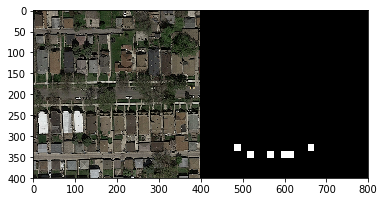

In [11]:
IDX = 16
patches_idx = X[625*IDX:625*(IDX+1)]

Z_idx = model.predict(patches_idx)
labels_idx = (Z_idx > 0.5) *1 

im = label_to_img(400, 400, 16, 16, labels_idx)
plt.imshow(concatenate_images(imgs[IDX], im))

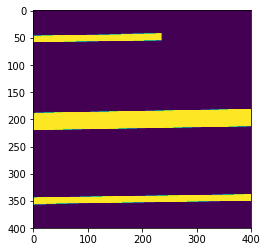

In [12]:
plt.imshow(gt_imgs[IDX])

In [30]:
Z_train = model.predict(X_train)
Z_train = ((Z_train < 0.5) * 1).reshape(N_train)
accuracy_train = np.sum(np.abs(Z_train - Y_train))/N_train
print(accuracy_train)

0.7423


In [14]:
from sklearn.metrics import f1_score
f1_score(Y_train,Z_train)

0.3854787851062787

# Check what happened on the validation

In [ ]:
Z_valid = model.predict(X_valid)

In [ ]:
Z_valid = ((Z_valid < 0.5) * 1).reshape(N_valid)
accuracy_valid = np.sum(np.abs(Z_valid - Y_valid))/N_valid
print(accuracy_valid)

In [ ]:
from sklearn.metrics import f1_score
f1_score(Y_valid,Z_valid)

# predict on test

In [ ]:
test_images = pick_test_images()

print(np.array(test_images).shape)

n_test = len(test_images)

test_patches = [img_crop(test_images[i], patch_size, patch_size) for i in range(n_test)]

test_patches = np.asarray([test_patches[i][j] for i in range(len(test_patches)) for j in range(len(test_patches[i]))])

In [ ]:
Z = model.predict(test_patches)

In [ ]:
labels1D = (Z < 0.5 ) * 1
labels1D.shape
labels = labels1D.reshape(50,-1)
print(labels.shape)

In [ ]:
IDX = 9
im = label_to_img(608, 608, 16, 16, labels[IDX])
plt.imshow(concatenate_images(test_images[IDX], im))

In [ ]:
MY_masks_to_submission('dummsdsy_submission.csv', labels)